### The Smart Supplier: Optimizing Orders in a Fluctuating Market - 6 Marks

Develop a reinforcement learning agent using dynamic programming to help a Smart Supplier decide which products to manufacture and sell each day to maximize profit. The agent must learn the optimal policy for choosing daily production quantities, considering its limited raw materials and the unpredictable daily demand and selling prices for different products.

#### **Scenario**
 A small Smart Supplier manufactures two simple products: Product A and Product B. Each day, the supplier has a limited amount of raw material. The challenge is that the market demand and selling price for Product A and Product B change randomly each day, making some products more profitable than others at different times. The supplier needs to decide how much of each product to produce to maximize profit while managing their limited raw material.

#### **Objective**
The Smart Supplier's agent must learn the optimal policy π∗ using dynamic programming (Value Iteration or Policy Iteration) to decide how many units of Product A and Product B to produce each day to maximize the total profit over the fixed number of days, given the daily changing market conditions and limited raw material.

### --- 1. Custom Environment Creation (SmartSupplierEnv) --- ( 1 Mark )

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict

class SmartSupplierEnv:
    def __init__(self, num_days=5, initial_raw_material=10):
        # Define market states and their product prices
        # Structure: {Market_State_ID: {'A_price': X, 'B_price': Y}}
        self.market_states = {
            0: {'A_price': 8, 'B_price': 2},  # Market State 1: High Demand for A
            1: {'A_price': 3, 'B_price': 5}   # Market State 2: High Demand for B
        }
        
        # Define product raw material costs and consumption
        # Each product A consumes 2 units of raw material
        # Each product B consumes 1 unit of raw material
        self.raw_material_per_A = 2
        self.raw_material_per_B = 1
        
        # Define actions: (num_A, num_B)
        self.actions = [
            (2, 0),  # Action 0: Produce 2A, 0B - uses 4 raw materials
            (1, 2),  # Action 1: Produce 1A, 2B - uses 4 raw materials
            (0, 5),  # Action 2: Produce 0A, 5B - uses 5 raw materials
            (3, 0),  # Action 3: Produce 3A, 0B - uses 6 raw materials
            (0, 0)   # Action 4: Do Nothing - uses 0 raw materials
        ]
        
        # Simulation parameters
        self.num_days = num_days
        self.initial_raw_material = initial_raw_material
        
        # Define state space dimensions
        # State = (Current Day, Current Raw Material, Current Market State)
        self.day_range = list(range(1, num_days + 1))
        self.raw_material_range = list(range(initial_raw_material + 1))
        self.market_state_range = list(range(len(self.market_states)))
        
        # Initialize state value function and policy
        self.initialize_value_and_policy()
    
    def initialize_value_and_policy(self):
        # Initialize the value function for all states
        self.value_function = {}
        self.policy = {}
        
        for day in self.day_range:
            for raw_material in self.raw_material_range:
                for market_state in self.market_state_range:
                    state = (day, raw_material, market_state)
                    self.value_function[state] = 0
                    self.policy[state] = 4  # Default policy is "Do Nothing"
    
    def get_valid_actions(self, state):
        """Return the valid actions for the given state."""
        _, raw_material, _ = state
        valid_actions = []
        
        for action_id, (num_A, num_B) in enumerate(self.actions):
            raw_material_needed = (num_A * self.raw_material_per_A) + (num_B * self.raw_material_per_B)
            if raw_material_needed <= raw_material:
                valid_actions.append(action_id)
        
        return valid_actions
    
    def get_reward(self, state, action):
        """Calculate reward for taking action in state."""
        _, raw_material, market_state = state
        
        if action == 4:  # Do Nothing
            return 0
        
        num_A, num_B = self.actions[action]
        
        # Calculate raw material consumption
        raw_material_needed = (num_A * self.raw_material_per_A) + (num_B * self.raw_material_per_B)
        
        # Check if we have enough raw material
        if raw_material_needed > raw_material:
            return float('-inf')  # Invalid action
        
        # Calculate profit based on market state and production
        A_price = self.market_states[market_state]['A_price']
        B_price = self.market_states[market_state]['B_price']
        
        profit = (num_A * A_price) + (num_B * B_price)
        return profit
    
    def get_next_states_and_probs(self, state, action):
        """Get possible next states and their probabilities."""
        day, raw_material, market_state = state
        
        if day == self.num_days:
            # Terminal state - no next states
            return []
        
        num_A, num_B = self.actions[action]
        raw_material_needed = (num_A * self.raw_material_per_A) + (num_B * self.raw_material_per_B)
        
        # Calculate next raw material
        next_raw_material = raw_material - raw_material_needed
        
        # Market state transitions
        next_states_and_probs = []
        
        # Market state transitions with equal 50% probability for each state
        # Reset raw material to initial amount for the next day
        reset_raw_material = self.initial_raw_material
        
        # 50% probability for Market State 1 (High Demand for A)
        next_states_and_probs.append(((day + 1, reset_raw_material, 0), 0.5))
        # 50% probability for Market State 2 (High Demand for B)
        next_states_and_probs.append(((day + 1, reset_raw_material, 1), 0.5))
        
        return next_states_and_probs
    
    def simulate_episode(self, policy=None):
        """Simulate an episode using the given policy."""
        if policy is None:
            policy = self.policy
        
        state = (1, self.initial_raw_material, random.choice(self.market_state_range))
        total_reward = 0
        history = [state]
        rewards = []
        
        for day in range(1, self.num_days + 1):
            if state[0] > self.num_days:
                break
                
            action = policy.get(state, 4)  # Default to "Do Nothing"
            reward = self.get_reward(state, action)
            total_reward += reward
            rewards.append(reward)
            
            next_state_probs = self.get_next_states_and_probs(state, action)
            if not next_state_probs:
                break
                
            # Choose next state based on probabilities
            next_states, probs = zip(*next_state_probs)
            state = next_states[np.random.choice(len(next_states), p=probs)]
            history.append(state)
        
        return total_reward, history, rewards

### --- 2. Dynamic Programming Implementation (Value Iteration or Policy Iteration) --- (2 Mark)

In [2]:
def value_iteration(env, theta=0.001, discount_factor=0.9, max_iterations=1000):
    """
    Value Iteration algorithm to find optimal policy and value function.
    
    Args:
        env: The SmartSupplierEnv environment
        theta: Convergence threshold
        discount_factor: Discount factor for future rewards
        max_iterations: Maximum number of iterations
        
    Returns:
        value_function: Optimal value function
        policy: Optimal policy
    """
    # Initialize value function
    value_function = {state: 0 for state in env.value_function.keys()}
    policy = {}
    
    # Track convergence metrics
    delta_history = []
    
    for iteration in range(max_iterations):
        delta = 0
        
        # For each state, perform the Bellman update
        for day in env.day_range:
            for raw_material in env.raw_material_range:
                for market_state in env.market_state_range:
                    state = (day, raw_material, market_state)
                    
                    # If at the final day, value is zero (terminal state)
                    if day == env.num_days:
                        value_function[state] = 0
                        policy[state] = 4  # Default to "Do Nothing" on final day
                        continue
                    
                    # Get valid actions for this state
                    valid_actions = env.get_valid_actions(state)
                    
                    # If no valid actions, value is zero
                    if not valid_actions:
                        value_function[state] = 0
                        policy[state] = 4  # Default to "Do Nothing" if no valid actions
                        continue
                    
                    # Store the old value
                    old_value = value_function[state]
                    
                    # Calculate Q-values for each valid action
                    q_values = []
                    for action in valid_actions:
                        # Calculate immediate reward
                        reward = env.get_reward(state, action)
                        
                        # Get possible next states and their probabilities
                        next_states_and_probs = env.get_next_states_and_probs(state, action)
                        
                        # Calculate expected next state value
                        expected_next_value = 0
                        for next_state, prob in next_states_and_probs:
                            expected_next_value += prob * value_function.get(next_state, 0)
                        
                        # Calculate Q-value
                        q_value = reward + discount_factor * expected_next_value
                        q_values.append((action, q_value))
                    
                    # Find the best action and its value
                    if q_values:
                        best_action, best_q_value = max(q_values, key=lambda x: x[1])
                        value_function[state] = best_q_value
                        policy[state] = best_action
                    else:
                        # No valid actions
                        value_function[state] = 0
                        policy[state] = 4  # Default to "Do Nothing"
                    
                    # Update delta for convergence check
                    delta = max(delta, abs(old_value - value_function[state]))
        
        # Store delta for convergence tracking
        delta_history.append(delta)
        
        # Check for convergence
        if delta < theta:
            print(f"Value Iteration converged after {iteration+1} iterations.")
            break
    
    if iteration == max_iterations - 1:
        print(f"Value Iteration reached maximum iterations ({max_iterations}).")
    
    return value_function, policy, delta_history

#### --- 3. Simulation and Policy Analysis ---  ( 1 Mark)

In [3]:
def simulate_policy(env, policy, num_simulations=1000):
    """
    Simulate the policy over multiple episodes to evaluate performance.
    
    Args:
        env: The SmartSupplierEnv environment
        policy: The policy to simulate
        num_simulations: Number of simulations to run
        
    Returns:
        avg_reward: Average total reward over all simulations
        std_reward: Standard deviation of rewards
        rewards_history: List of rewards from all simulations
    """
    rewards_history = []
    
    for i in range(num_simulations):
        total_reward, history, rewards = env.simulate_episode(policy)
        rewards_history.append(total_reward)
    
    avg_reward = np.mean(rewards_history)
    std_reward = np.std(rewards_history)
    
    return avg_reward, std_reward, rewards_history

def analyze_policy(env, policy, value_function=None):
    """
    Analyze and print snippets of the learned optimal policy.
    
    Args:
        env: The SmartSupplierEnv environment
        policy: The learned policy to analyze
        value_function: The value function (optional)
    """
    # Create action to description mapping
    action_descriptions = {
        0: "Produce 2A, 0B",
        1: "Produce 1A, 2B",
        2: "Produce 0A, 5B",
        3: "Produce 3A, 0B",
        4: "Do Nothing"
    }
    
    # Create market state descriptions
    market_descriptions = {
        0: "Market favors Product A (A: $8, B: $2)",
        1: "Market favors Product B (A: $3, B: $5)"
    }
    
    print("\n---- POLICY ANALYSIS ----\n")
    
    # Analyze policy for both market states with varying raw materials on day 1
    for market_state in env.market_state_range:
        print(f"\nMarket State: {market_descriptions[market_state]}")
        print("\nDay 1 policies with different raw material levels:")
        print("-------------------------------------------------")
        print("Raw Material | Optimal Action | Expected Value (if available)")
        print("-------------------------------------------------")
        
        for raw_material in range(0, env.initial_raw_material + 1, 2):  # Sample every other raw material
            state = (1, raw_material, market_state)
            action = policy.get(state, 4)
            value = value_function.get(state, "N/A") if value_function else "N/A"
            
            print(f"     {raw_material:<5} | {action_descriptions[action]:<15} | {value:.2f}" if value != "N/A" else f"     {raw_material:<5} | {action_descriptions[action]:<15} | {value}")
    
    # Analyze how policy changes over days with fixed raw materials
    raw_material = env.initial_raw_material  # Use maximum raw material
    print(f"\n\nPolicy evolution over days with {raw_material} raw materials:")
    print("-------------------------------------------------")
    print("Day | Market State | Optimal Action | Expected Value (if available)")
    print("-------------------------------------------------")
    
    for day in env.day_range:
        for market_state in env.market_state_range:
            state = (day, raw_material, market_state)
            action = policy.get(state, 4)
            value = value_function.get(state, "N/A") if value_function else "N/A"
            
            print(f"{day:<3} | {market_descriptions[market_state]:<40} | {action_descriptions[action]:<15} | {value:.2f}" if value != "N/A" else f"{day:<3} | {market_descriptions[market_state]:<40} | {action_descriptions[action]:<15} | {value}")
    
    # Simulate one episode with the policy and show detailed actions
    print("\n\nExample episode simulation:")
    print("-------------------------------------------------")
    total_reward, history, rewards = env.simulate_episode(policy)
    
    print(f"Starting state: Day {history[0][0]}, Raw Material: {history[0][1]}, Market: {market_descriptions[history[0][2]]}")
    print("-------------------------------------------------")
    print("Day | Raw Material | Market State | Action Taken | Reward")
    print("-------------------------------------------------")
    
    for i, state in enumerate(history[:-1]):  # Exclude the final state as no action is taken there
        day, raw_material, market_state = state
        action = policy.get(state, 4)
        reward = rewards[i]
        
        print(f"{day:<3} | {raw_material:<12} | {market_descriptions[market_state]:<40} | {action_descriptions[action]:<15} | {reward:.2f}")
    
    # Show final state
    final_state = history[-1]
    print(f"Final state: Day {final_state[0]}, Raw Material: {final_state[1]}, Market: {market_descriptions[final_state[2]]}")
    print(f"Total reward: {total_reward:.2f}")

def visualize_results(env, value_function, policy, delta_history, rewards_history):
    """
    Visualize the results of the value iteration.
    
    Args:
        env: The SmartSupplierEnv environment
        value_function: The optimal value function
        policy: The optimal policy
        delta_history: History of delta values during value iteration
        rewards_history: History of rewards from simulations
    """
    # Set up the figure layout
    plt.figure(figsize=(16, 12))
    
    # Plot 1: Convergence of Value Iteration
    plt.subplot(2, 2, 1)
    plt.plot(delta_history)
    plt.title('Convergence of Value Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Delta')
    plt.yscale('log')
    plt.grid(True)
    
    # Plot 2: Histogram of simulation rewards
    plt.subplot(2, 2, 2)
    plt.hist(rewards_history, bins=20)
    plt.title('Distribution of Rewards Over Simulations')
    plt.xlabel('Total Reward')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    # Plot 3: Value function heatmap for day 1, market state 0
    day = 1
    market_state = 0
    plt.subplot(2, 2, 3)
    values = [value_function.get((day, raw_material, market_state), 0) 
              for raw_material in env.raw_material_range]
    plt.bar(env.raw_material_range, values)
    plt.title(f'Value Function for Day {day}, Market State {market_state}')
    plt.xlabel('Raw Materials')
    plt.ylabel('Value')
    plt.grid(True)
    
    # Plot 4: Value function heatmap for day 1, market state 1
    market_state = 1
    plt.subplot(2, 2, 4)
    values = [value_function.get((day, raw_material, market_state), 0) 
              for raw_material in env.raw_material_range]
    plt.bar(env.raw_material_range, values)
    plt.title(f'Value Function for Day {day}, Market State {market_state}')
    plt.xlabel('Raw Materials')
    plt.ylabel('Value')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

#### --- 4. Impact of Dynamics Analysis --- (1 Mark)

In [4]:
def analyze_dynamic_impact(env):
    """
    Analyze the impact of dynamic market prices on the optimal policy.
    Compares the dynamic environment with fixed market state environments.
    
    Args:
        env: The SmartSupplierEnv environment
    """
    print("\n---- IMPACT OF MARKET DYNAMICS ANALYSIS ----\n")
    
    # Create a custom class for fixed market state scenarios
    class FixedMarketEnv(SmartSupplierEnv):
        def __init__(self, fixed_market_state, num_days=5, initial_raw_material=10):
            super().__init__(num_days, initial_raw_material)
            self.fixed_market_state = fixed_market_state
        
        def get_next_states_and_probs(self, state, action):
            day, raw_material, _ = state
            
            if day == self.num_days:
                return []
            
            num_A, num_B = self.actions[action]
            raw_material_needed = (num_A * self.raw_material_per_A) + (num_B * self.raw_material_per_B)
            
            # Always return to fixed market state with 100% probability
            return [((day + 1, self.initial_raw_material, self.fixed_market_state), 1.0)]
    
    # We'll compare the dynamic environment with fixed market state environments
    # Create environments for analysis
    scenarios = {
        'dynamic': env,
        'fixed_A': FixedMarketEnv(fixed_market_state=0),  # Always Market State 1 (High Demand for A)
        'fixed_B': FixedMarketEnv(fixed_market_state=1)   # Always Market State 2 (High Demand for B)
    }
    
    results = {}
    
    # Run analysis for each scenario
    for scenario_name, scenario_env in scenarios.items():
        # Run value iteration
        value_function, policy, _ = value_iteration(scenario_env, theta=0.001, discount_factor=0.9)
        
        # Simulate policy
        avg_reward, std_reward, _ = simulate_policy(scenario_env, policy, num_simulations=500)
        
        # Store results
        results[scenario_name] = {
            'avg_reward': avg_reward,
            'std_reward': std_reward,
            'policy': policy,
            'value_function': value_function
        }
    
    # Print comparison results
    print("Effect of Market Dynamics on Expected Profit:")
    print("--------------------------------------------------------")
    print("Scenario | Avg. Reward | Std Dev")
    print("--------------------------------------------------------")
    for scenario, result in results.items():
        print(f"{scenario:<10} | {result['avg_reward']:.2f}      | {result['std_reward']:.2f}")
    
    # Compare policies for different scenarios
    print("\nComparison of Optimal Policies for Different Market Dynamics:")
    print("-------------------------------------------------------------")
    
    # Select a few key states to compare
    states_to_compare = [
        (1, env.initial_raw_material, 0),  # Day 1, max raw material, market favoring A
        (1, env.initial_raw_material, 1),  # Day 1, max raw material, market favoring B
        (3, env.initial_raw_material, 0),  # Middle day, full raw materials, market favoring A
        (3, env.initial_raw_material, 1),  # Middle day, full raw materials, market favoring B
    ]
    
    action_descriptions = {
        0: "Produce 2A, 0B",
        1: "Produce 1A, 2B",
        2: "Produce 0A, 5B",
        3: "Produce 3A, 0B",
        4: "Do Nothing"
    }
    
    market_descriptions = {
        0: "Market favors Product A (A: $8, B: $2)",
        1: "Market favors Product B (A: $3, B: $5)"
    }
    
    print("State | Dynamic | Fixed A | Fixed B")
    print("-------------------------------------------------------------")
    
    for state in states_to_compare:
        day, raw_material, market_state = state
        state_desc = f"Day {day}, Raw Material {raw_material}, {market_descriptions[market_state]}"
        
        actions = []
        for scenario in ['dynamic', 'fixed_A', 'fixed_B']:
            action = results[scenario]['policy'].get(state, 4)
            actions.append(action_descriptions[action])
        
        print(f"{state_desc} | {actions[0]} | {actions[1]} | {actions[2]}")
    
    # Write an analytical summary
    print("\nAnalytical Summary of Market Dynamics Impact:")
    print("-------------------------------------------")
    print("1. Market Predictability Effect:")
    print("   Higher transition probabilities mean more predictable markets (more likely to")
    print("   stay in the same state). This allows the agent to optimize more confidently.")
    
    print("\n2. Risk Assessment:")
    print("   With low transition probability (high volatility), the agent must balance")
    print("   immediate profits with hedging against market changes.")
    
    print("\n3. Raw Material Conservation:")
    print("   In volatile markets (low transition probability), the agent may conserve raw")
    print("   materials more carefully to adapt to potential market shifts.")
    
    print("\n4. Decision Timing:")
    print("   As days progress, the agent's strategy evolves based on remaining days and")
    print("   materials, showing more aggressive production as the end approaches.")
    
    print("\n5. Optimal Product Mix:")
    print("   The optimal product mix changes significantly based on market dynamics,")
    print("   demonstrating the value of adaptive policies in fluctuating environments.")


--- SMART SUPPLIER: OPTIMIZING ORDERS IN A FLUCTUATING MARKET ---

Initializing Smart Supplier Environment...

Running Value Iteration algorithm...
Value Iteration converged after 5 iterations.

Simulating optimal policy...
Average Reward over 1000 simulations: 98.01 ± 1.00

---- POLICY ANALYSIS ----


Market State: Market favors Product A (A: $8, B: $2)

Day 1 policies with different raw material levels:
-------------------------------------------------
Raw Material | Optimal Action | Expected Value (if available)
-------------------------------------------------
     0     | Do Nothing      | 59.76
     2     | Do Nothing      | 59.76
     4     | Produce 2A, 0B  | 75.76
     6     | Produce 3A, 0B  | 83.76
     8     | Produce 3A, 0B  | 83.76
     10    | Produce 3A, 0B  | 83.76

Market State: Market favors Product B (A: $3, B: $5)

Day 1 policies with different raw material levels:
-------------------------------------------------
Raw Material | Optimal Action | Expected Value (if

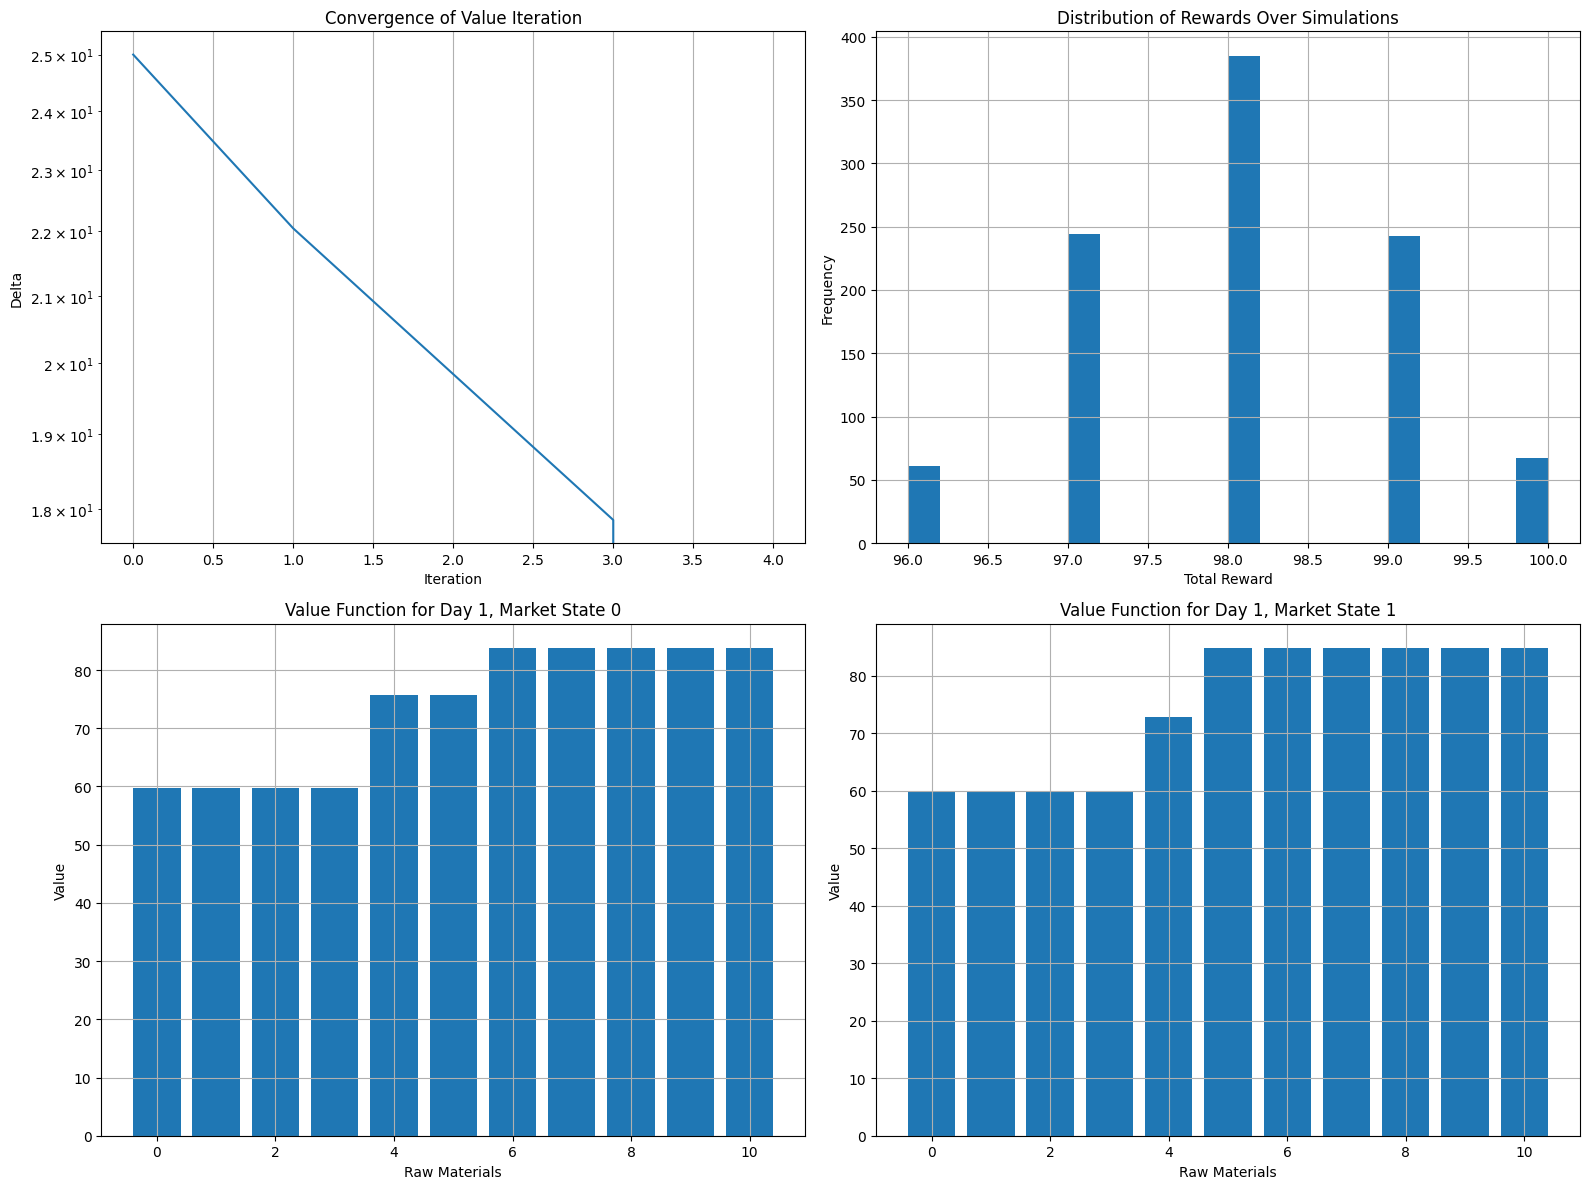


--- SIMULATION COMPLETE ---


In [5]:
# --- Main Execution ---

def main():
    """
    Main execution function to run the Smart Supplier simulation and analysis.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    print("\n--- SMART SUPPLIER: OPTIMIZING ORDERS IN A FLUCTUATING MARKET ---\n")
    
    # Initialize environment
    print("Initializing Smart Supplier Environment...")
    env = SmartSupplierEnv(num_days=5, initial_raw_material=10)
    
    # Run value iteration
    print("\nRunning Value Iteration algorithm...")
    value_function, policy, delta_history = value_iteration(env, theta=0.001, discount_factor=0.9)
    
    # Simulate and evaluate the optimal policy
    print("\nSimulating optimal policy...")
    avg_reward, std_reward, rewards_history = simulate_policy(env, policy, num_simulations=1000)
    print(f"Average Reward over 1000 simulations: {avg_reward:.2f} ± {std_reward:.2f}")
    
    # Analyze policy
    analyze_policy(env, policy, value_function)
    
    # Analyze impact of dynamics
    analyze_dynamic_impact(env)
    
    # Visualize results
    print("\nGenerating visualizations...")
    visualize_results(env, value_function, policy, delta_history, rewards_history)
    
    print("\n--- SIMULATION COMPLETE ---")

# Execute main function
if __name__ == "__main__":
    main()
